Loaded data with shape: x=(231, 60, 2), y=(231,)
Using device: cuda

Model Architecture (VeryLarge):
EOG_CNN_VeryLarge(
  (conv1): Conv1d(2, 64, kernel_size=(7,), stride=(1,), padding=(3,))
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu2): ReLU()
  (pool2): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu3): ReLU()
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1792, out_features=128, bias=True)
  (relu_fc1): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Calculated flattened size for FC layer (based on seq_length=60): 1792

Starting training for 50 epochs...
Monitoring Test Loss, Accuracy, an

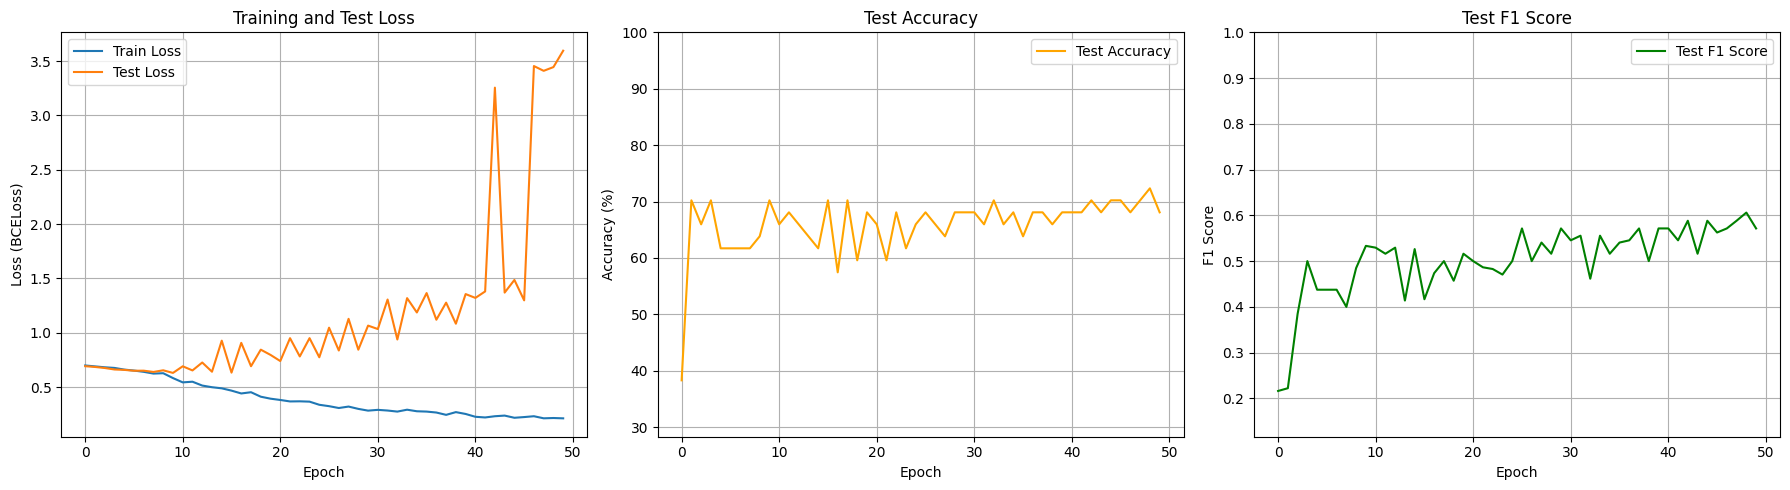

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score # Import f1_score
import matplotlib.pyplot as plt
import numpy as np

# Assume preprocess_data exists or use placeholder
try:
    from preprocess import preprocess_data
except ImportError:
    preprocess_data = None # Flag that it's missing

# Define the data dimension (sequence length) as a variable
data_dim = 60 # This should match the actual sequence length of your data
input_channels = 2 # This should match the feature dimension of your data

input_sources = ["nico", "sofia"] # Example sources
x_final = None
y_final = None

# Use placeholder data generation if preprocess_data is not available
if preprocess_data:
    try:
        final_data = [preprocess_data(source, data_dim) for source in input_sources]
        x_final, y_final = [np.concatenate([data_tuple[i] for data_tuple in final_data], axis=0) for i in range(2)]
        print(f"Loaded data with shape: x={x_final.shape}, y={y_final.shape}")
        # Ensure x_final has shape (num_samples, data_dim, input_channels)
        if len(x_final.shape) != 3 or x_final.shape[1] != data_dim or x_final.shape[2] != input_channels:
             raise ValueError(f"x_final shape {x_final.shape} is inconsistent with data_dim={data_dim} and input_channels={input_channels}")
    except Exception as e:
        print(f"Error loading or processing data with preprocess_data: {e}")
        print("Falling back to placeholder data generation.")
        x_final, y_final = None, None # Reset to trigger placeholder

if x_final is None or y_final is None:
    print("Generating placeholder data...")
    num_samples = 1000
    x_final = np.random.rand(num_samples, data_dim, input_channels)
    y_final = np.random.randint(0, 2, num_samples)
    print(f"Generated placeholder data with shape: x={x_final.shape}, y={y_final.shape}")


X = torch.FloatTensor(x_final)
y = torch.FloatTensor(y_final).unsqueeze(1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- Model Definition (Bigger Version) ---
class EOG_CNN_VeryLarge(nn.Module):
    # Increased channel sizes and FC layer size
    def __init__(self, input_channels=2, seq_length=60): # Default seq_length matches data_dim
        super(EOG_CNN_VeryLarge, self).__init__()
        self.seq_length = seq_length
        self.input_channels = input_channels

        self.conv1 = nn.Conv1d(in_channels=self.input_channels,
                               out_channels=64, # Increased
                               kernel_size=7,
                               padding=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=3, stride=2)

        self.conv2 = nn.Conv1d(in_channels=64, # Increased in_channels
                               out_channels=128, # Increased out_channels
                               kernel_size=5,
                               padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=3, stride=2)

        self.conv3 = nn.Conv1d(in_channels=128, # Increased in_channels
                               out_channels=256, # Increased out_channels
                               kernel_size=3,
                               padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        # Calculate flattened size dynamically
        with torch.no_grad():
            dummy_input = torch.zeros(1, self.input_channels, self.seq_length)
            dummy_output = self._forward_features(dummy_input)
            self.flattened_size = dummy_output.numel()
            if self.flattened_size == 0:
                raise ValueError(f"Flattened size is 0. Check Conv/Pool layers and seq_length ({self.seq_length}). Output shape after convs: {dummy_output.shape}")


        self.fc1 = nn.Linear(self.flattened_size, 128) # Increased FC size
        self.relu_fc1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5) # Dropout remains important, maybe even increase slightly if overfitting
        self.fc2 = nn.Linear(128, 1) # Input matches fc1 output
        self.sigmoid = nn.Sigmoid()

    def _forward_features(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        return x

    def forward(self, x):
        # Input shape: (batch_size, seq_length, input_channels)
        x = x.permute(0, 2, 1) # Reshape to (batch_size, input_channels, seq_length)

        x = self._forward_features(x)
        x = x.view(x.size(0), -1) # Flatten

        if x.shape[1] != self.fc1.in_features:
             raise RuntimeError(f"Shape mismatch before FC1: Got {x.shape[1]}, expected {self.fc1.in_features}. "
                                f"Calculated flattened_size: {self.flattened_size}. Check model architecture and seq_length ({self.seq_length}).")

        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# --- Setup Device, Model, Criterion, Optimizer ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the bigger model
model = EOG_CNN_VeryLarge(input_channels=input_channels, seq_length=data_dim).to(device)
print("\nModel Architecture (VeryLarge):")
print(model)
# Check flattened size calculation
try:
    print(f"\nCalculated flattened size for FC layer (based on seq_length={data_dim}): {model.flattened_size}")
except AttributeError:
     print("\nWarning: Could not access model.flattened_size. May occur if init failed.")


criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005) # Consider slightly lower LR for bigger models if unstable

# --- Training Function (Modified for F1 Score Monitoring) ---
# Note: We monitor F1 score, but still optimize using BCELoss.
# Directly optimizing for F1 is complex as it's non-differentiable.
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=1000, device='cpu'):
    train_losses = []
    test_losses = []
    test_accuracies = []
    test_f1_scores = [] # Store F1 scores

    print(f"\nStarting training for {epochs} epochs...")
    print("Monitoring Test Loss, Accuracy, and F1 Score.")

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for batch_idx, (batch_x, batch_y) in enumerate(train_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            try:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                running_train_loss += loss.item() * batch_x.size(0)
            except RuntimeError as e:
                print(f"\nError during forward/backward pass in training (batch {batch_idx}): {e}")
                print(f"Input batch_x shape: {batch_x.shape}")
                raise e # Re-raise error after printing info

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Evaluation phase
        model.eval()
        running_test_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch_idx, (batch_x, batch_y) in enumerate(test_loader):
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                try:
                    outputs = model(batch_x)
                    loss = criterion(outputs, batch_y)
                    running_test_loss += loss.item() * batch_x.size(0)

                    predicted = (outputs > 0.5).float() # Standard threshold 0.5

                    # Store predictions and labels for F1 calculation later
                    all_preds.append(predicted.cpu().numpy())
                    all_labels.append(batch_y.cpu().numpy())

                except RuntimeError as e:
                    print(f"\nError during forward pass in testing (batch {batch_idx}): {e}")
                    print(f"Input batch_x shape: {batch_x.shape}")
                    raise e # Re-raise error

        epoch_test_loss = running_test_loss / len(test_loader.dataset)
        test_losses.append(epoch_test_loss)

        # Concatenate all predictions and labels from the epoch
        all_preds_np = np.concatenate(all_preds)
        all_labels_np = np.concatenate(all_labels)

        # Calculate accuracy
        correct_predictions = np.sum(all_preds_np == all_labels_np)
        total_samples = len(all_labels_np)
        epoch_accuracy = 100 * correct_predictions / total_samples
        test_accuracies.append(epoch_accuracy)

        # Calculate F1 Score
        # Use zero_division=0 to return 0 if precision and recall are both 0
        epoch_f1 = f1_score(all_labels_np, all_preds_np, zero_division=0)
        test_f1_scores.append(epoch_f1)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], '
                  f'Train Loss: {epoch_train_loss:.4f}, '
                  f'Test Loss: {epoch_test_loss:.4f}, '
                  f'Test Accuracy: {epoch_accuracy:.2f}%, '
                  f'Test F1 Score: {epoch_f1:.4f}') # Print F1

    print("Training finished.")
    # Return F1 scores along with others
    return train_losses, test_losses, test_accuracies, test_f1_scores

# --- Training Execution and Visualization ---
if X_train is not None and y_train is not None:
    try:
        # Pass device to train_model
        train_losses, test_losses, test_accuracies, test_f1_scores = train_model(
            model, train_loader, test_loader, criterion, optimizer, epochs=50, device=device
        )

        plt.figure(figsize=(18, 5)) # Wider figure for 3 plots

        plt.subplot(1, 3, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (BCELoss)')
        plt.title('Training and Test Loss')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 3, 2)
        plt.plot(test_accuracies, label='Test Accuracy', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Test Accuracy')
        plt.legend()
        plt.grid(True)
        plt.ylim(min(max(0, min(test_accuracies)-10), 90) , 100) # Adjust ylim for accuracy

        plt.subplot(1, 3, 3) # Third subplot for F1 Score
        plt.plot(test_f1_scores, label='Test F1 Score', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.title('Test F1 Score')
        plt.legend()
        plt.grid(True)
        plt.ylim(min(max(0, min(test_f1_scores)-0.1), 0.9) , 1.0) # Adjust ylim for F1


        plt.tight_layout()
        plt.show()

    except RuntimeError as e:
        print(f"\n--- Training failed with RuntimeError ---")
        print(e)
        print("Please double-check model architecture, data dimensions, and device compatibility.")
        print(f"Data details: data_dim={data_dim}, input_channels={input_channels}")
        if x_final is not None:
            print(f"x_final shape: {x_final.shape}")

    except ValueError as e:
        print(f"\n--- Training failed with ValueError ---")
        print(e)
        print("This might be due to issues in data processing or model initialization (e.g., flattened size calculation).")

else:
    print("Skipping training and visualization as data (X_train/y_train) is not available.")